In [1]:
import os, sys, argparse
import pandas as pd
import numpy as np

import pickle
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
parser = argparse.ArgumentParser(description='heatmap creator')
parser.add_argument('-o', '--output', type=str, default='-', action='store', help='target')
parser.add_argument('-d', '--data', type=str, default='alpha', choices=['alpha', 'amazon', 'epinions', 'otc'], help='data name')
parser.add_argument('-a', '--alg', type=str, default='bad', choices=['bn', 'feagle', 'fraudar', 'trust', 'rsd', 'bad'], help='alg name')

if bool(getattr(sys, 'ps1', sys.flags.interactive)):
    from tqdm import tqdm_notebook as tqdm
    print('interactive mode')
    parsed = parser.parse_args(['--data', 'alpha', '--alg', 'bn'])
else:
    from tqdm import tqdm
    print('script mode')
    parsed = parser.parse_args(sys.argv[1:])
    display=print

print(parsed)

interactive mode
Namespace(alg='bn', data='alpha', output='-')


In [3]:
alg_list = ['bn', 'feagle', 'fraudar', 'trust', 'rsd', 'bad', 'rev2']
data_list = ['alpha', 'amazon', 'epinions', 'otc']
q_range = [0.02, 0.1, 0.2]
met_list = ['f1', 'prec', 'recl']

k_range = np.arange(10) / 10
n_range = list(range(0, 51, 5))
n_range[0] = 1

In [4]:
def plot_one_heatmap(fig, ax, plot_data, title=''):
    heat = ax.pcolor(plot_data)
    
    u_new = plot_data[1:, :].min()
    u_old = plot_data[0, :].mean()
    
    k_new, n_new = np.unravel_index(plot_data[1:, :].argmin(), plot_data[1:, :].shape)
    # because k_new starts from 1
    k_new += 1
    # print(k_range[k_new], n_range[n_new])
    
    u_change = (u_new - u_old) / u_old
    t = '%s\n new %.3f, old %.3f, change %.3f\n k: %.1f, N:%d' %(title, u_new, u_old, u_change, k_range[k_new], n_range[n_new])
    ax.set_title(t)

    ax.set_xticks(range(len(n_range)))
    ax.set_xticklabels(n_range)

    ax.set_yticks(range(len(k_range)))
    ax.set_yticklabels(k_range)

    ax.set_xlabel('N: number of fair reviews')
    ax.set_ylabel('k: fraction of sockpuppets')

    return heat, [u_change, k_range[k_new], n_range[n_new]]

In [5]:
def create_heatmaps(alg, data):
    eval_path = '../res/%s/eval-%s.pkl' %(alg, data)
    print(eval_path)
    if not os.path.exists(eval_path):
        print(alg, data, 'not exists')
        return None, {qq: {met: None for met in met_list} for qq in q_range}
    
    with open(eval_path, 'rb') as fp:
        metrics_dict = pickle.load(fp)
    
    q_dict = {}
    ret = {}
    for q in range(3):
        heat_dict = {'f1': np.empty([10, 11]), 'prec': np.empty([10, 11]), 'recl': np.empty([10, 11])}
        
        for k, n in itertools.product(range(10), range(11)):
            heat_dict['f1'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['f1'][q_range[q]] for ind in range(50)])
            heat_dict['prec'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['prec'][q_range[q]] for ind in range(50)])
            heat_dict['recl'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['recl'][q_range[q]] for ind in range(50)])
        q_dict[q] = heat_dict
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for q in range(3):
        ret[q_range[q]] = {}
        h1,r1 = plot_one_heatmap(fig, axes[q, 0], q_dict[q]['f1'], title='f1 score @ q %.2f' %q_range[q])
        h2,r2 = plot_one_heatmap(fig, axes[q, 1], q_dict[q]['prec'], title='precision @ q %.2f' %q_range[q])
        h3,r3 = plot_one_heatmap(fig, axes[q, 2], q_dict[q]['recl'], title='recall @ q %.2f' %q_range[q])
        ret[q_range[q]]['f1'] = r1
        ret[q_range[q]]['prec'] = r2
        ret[q_range[q]]['recl'] = r3
    
    # cax = fig.add_axes([0.98, 0, 0.01, 1])
    # cax = fig.add_axes([0, 0.02, 1, 0.01])
    # fig.colorbar(h1, orientation='horizontal', cax=cax)
    fig.colorbar(h1)
    fig.tight_layout()
    
    return fig, ret

../res/bn/eval-alpha.pkl


,0.02,0.1,0.2
f1,"[-0.3778666688671435, 0.9, 25]","[-0.05130932306750569, 0.9, 40]","[0.31092278059613826, 0.9, 50]"
prec,"[1.6740331491712712, 0.3, 1]","[1.4060137457044675, 0.1, 45]","[1.2494632367834713, 0.1, 45]"
recl,"[-0.6067667048885614, 0.9, 25]","[-0.3899026898087712, 0.9, 40]","[-0.10412936914900339, 0.9, 50]"


../res/feagle/eval-amazon.pkl
feagle amazon not exists


,0.02,0.1,0.2
f1,None,None,None
prec,None,None,None
recl,None,None,None


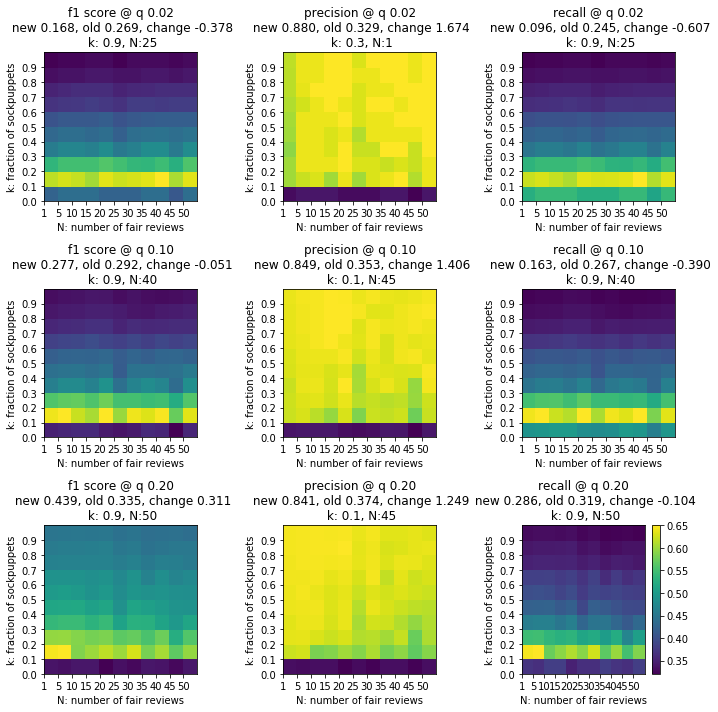

In [6]:
fig, ret = create_heatmaps(alg='bn', data='alpha')
display(pd.DataFrame(ret))
fig, ret = create_heatmaps(alg='feagle', data='amazon')
display(pd.DataFrame(ret))

In [7]:
reports = {met: {q: {alg: {data: {} for data in data_list} for alg in alg_list} for q in q_range} for met in met_list}

for alg in alg_list:
    for data in data_list:
        print(alg, data)
        fig, ret = create_heatmaps(alg, data)
        if fig != None:
            fig.savefig('../res/heatmaps/%s-%s.pdf' %(alg, data))
            plt.close()
        # pd.DataFrame(ret).to_csv('../res/heatmaps/%s-%s.csv' %(alg, data))
        for q in q_range:
            for met in met_list:
                if ret[q][met] != None:
                    reports[met][q][alg][data] = '%.3f k=%.2f n=%d' %tuple(ret[q][met])
                else:
                    reports[met][q][alg][data] = ''

for met in met_list:
    for q in q_range:
        print(met, q)
        pd.DataFrame(reports[met][q]).to_csv('../res/heatmaps/%s-%.2f.csv' %(met, q))

bn alpha
../res/bn/eval-alpha.pkl
bn amazon
../res/bn/eval-amazon.pkl
bn amazon not exists
bn epinions
../res/bn/eval-epinions.pkl
bn epinions not exists
bn otc
../res/bn/eval-otc.pkl
feagle alpha
../res/feagle/eval-alpha.pkl
feagle amazon
../res/feagle/eval-amazon.pkl
feagle amazon not exists
feagle epinions
../res/feagle/eval-epinions.pkl
feagle epinions not exists
feagle otc
../res/feagle/eval-otc.pkl
feagle otc not exists
fraudar alpha
../res/fraudar/eval-alpha.pkl
fraudar amazon
../res/fraudar/eval-amazon.pkl
fraudar amazon not exists
fraudar epinions
../res/fraudar/eval-epinions.pkl
fraudar epinions not exists
fraudar otc
../res/fraudar/eval-otc.pkl
fraudar otc not exists
trust alpha
../res/trust/eval-alpha.pkl
trust amazon
../res/trust/eval-amazon.pkl
trust amazon not exists
trust epinions
../res/trust/eval-epinions.pkl
trust epinions not exists
trust otc
../res/trust/eval-otc.pkl
rsd alpha
../res/rsd/eval-alpha.pkl
rsd alpha not exists
rsd amazon
../res/rsd/eval-amazon.pkl
rsd 